In [30]:
import numpy as np
import pandas as pd
import torch
import pyro
import os
import pyro.distributions as dist
import matplotlib.pyplot as plt
from pyro.distributions import constraints
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO
from pyro.infer.autoguide.guides import AutoDelta, AutoNormal
from pyro.infer.autoguide.initialization import *
import pyro.poutine as poutine
from pyro.optim import Adam

# Data

In [31]:
df = pd.read_csv('cifar-10h/data/cifar10h-raw.csv')

df.head()

,annotator_id,trial_index,is_attn_check,true_category,chosen_category,true_label,chosen_label,correct_guess,cifar10_test_test_idx,image_filename,subcategory,reaction_time,time_elapsed
0,0,0,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1342,1342
1,0,1,0,deer,horse,4,7,0,1118,alces_alces_s_000236.png,alces_alces,4305,6244
2,0,2,0,horse,horse,7,7,1,5965,stud_mare_s_001236.png,stud_mare,2811,9274
3,0,3,0,truck,automobile,9,1,0,6167,delivery_van_s_000100.png,delivery_van,1136,10610
4,0,4,0,deer,bird,4,2,0,373,elk_s_000359.png,elk,4410,15994


In [32]:
df = df[df['is_attn_check'] == 0]
df = df[df['reaction_time'] > 0]

df['reaction_time'] = df['reaction_time'] / 1000
df['image_id'] = df['image_filename'].astype('category').cat.codes
df['category_id'] = df['chosen_category'].astype('category').cat.codes

df.head()

,annotator_id,trial_index,is_attn_check,true_category,chosen_category,true_label,chosen_label,correct_guess,cifar10_test_test_idx,image_filename,subcategory,reaction_time,time_elapsed,image_id,category_id
0,0,0,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1.342,1342,1791,8
1,0,1,0,deer,horse,4,7,0,1118,alces_alces_s_000236.png,alces_alces,4.305,6244,275,7
2,0,2,0,horse,horse,7,7,1,5965,stud_mare_s_001236.png,stud_mare,2.811,9274,8573,7
3,0,3,0,truck,automobile,9,1,0,6167,delivery_van_s_000100.png,delivery_van,1.136,10610,3127,1
4,0,4,0,deer,bird,4,2,0,373,elk_s_000359.png,elk,4.410,15994,3649,2


### We'll also want to be able to plot images from the original dataset

In [33]:
import torchvision

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=torchvision.transforms.ToTensor())

Files already downloaded and verified


In [34]:
def plot_grid(img_ids):
  fig, axs = plt.subplots(4, 4, figsize=(15,15))
  for idx, img_id in enumerate(img_ids):
      i = idx // 4
      j = idx % 4
      axs[i][j].imshow(np.transpose(np.reshape(test_dataset[img_id][0], (3, 32,32)), (1,2,0)))

  plt.show()

In [35]:
df_img = df.pivot_table(index=['cifar10_test_test_idx'], values=['reaction_time'], aggfunc=np.mean)

most_uncertain = list(df_img.nlargest(16, columns=['reaction_time']).index)
most_certain = list(df_img.nsmallest(16, columns=['reaction_time']).index)

most_uncertain

[1739,
 5058,
 7781,
 1566,
 5563,
 2918,
 1146,
 3065,
 184,
 7735,
 9762,
 6325,
 9564,
 1994,
 7563,
 7560]

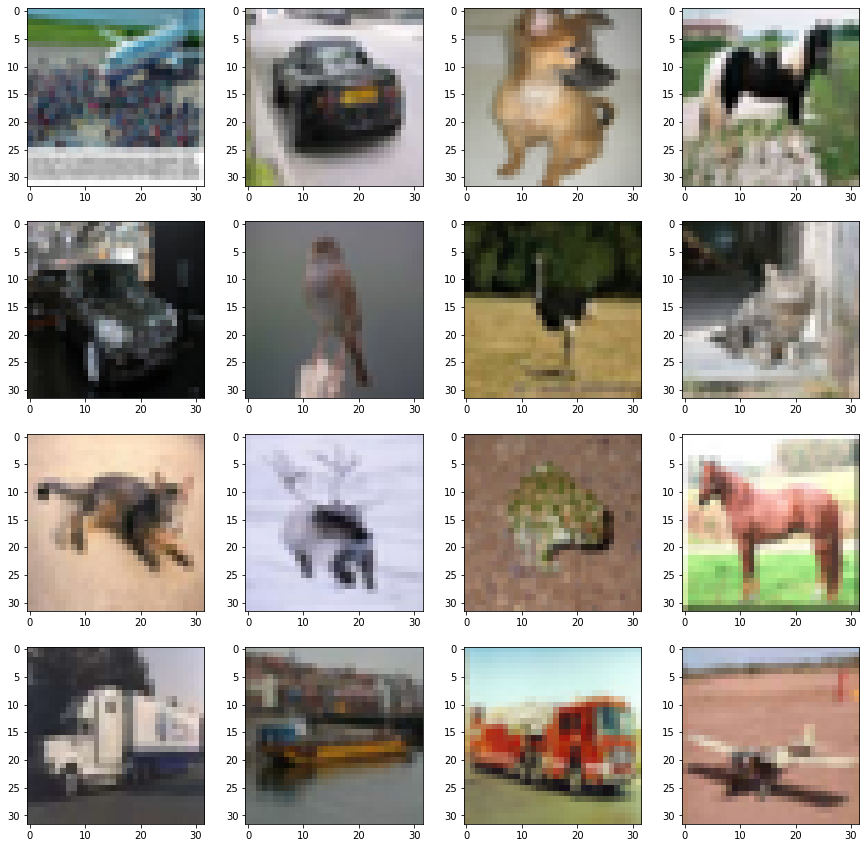

In [36]:
plot_grid(most_uncertain)

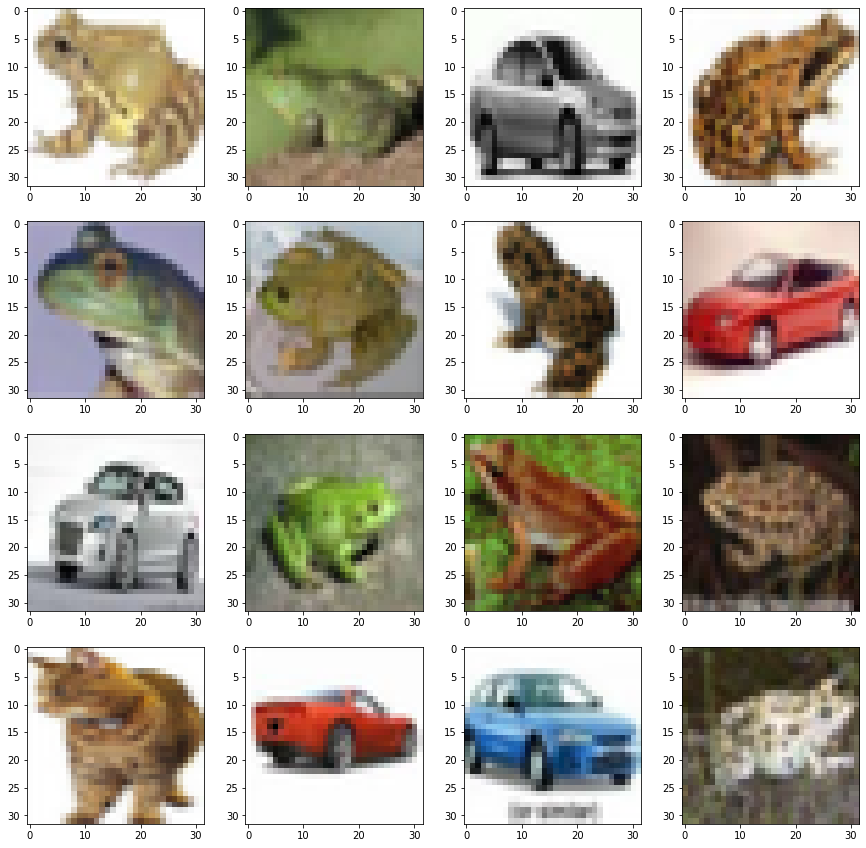

In [37]:
plot_grid(most_certain)

### Define some global vars for model

In [38]:
CLASSES = df['category_id'].unique()
NUM_CLASSES = len(CLASSES)

In [39]:
LARGE_VARIANCE = 10.
MEAN_REACTION_TIME = df['reaction_time'].mean()

MEAN_REACTION_TIME

1.9358507919282444

# Model

In [40]:
def model(image_idx, participant_idx, label, reaction_time,
          n_image, n_participant, n_response, n_categories):

  rate = pyro.sample("rate", dist.LogNormal(1., LARGE_VARIANCE))

  with pyro.plate('image_plate', n_image):
    dispersion = pyro.sample('dispersion', dist.Exponential(1.))
    locs = pyro.sample('locs', dist.LogNormal(dispersion, LARGE_VARIANCE))
    weights = pyro.sample('weights', dist.Dirichlet(dispersion.unsqueeze(-1) * torch.ones(n_categories)))

  with pyro.plate('participant_plate', n_participant):
    locs_participant = pyro.sample('locs_participant', dist.LogNormal(MEAN_REACTION_TIME, LARGE_VARIANCE))
    rates_participant = pyro.sample('rates_participant', dist.LogNormal(1., LARGE_VARIANCE))

  with pyro.plate(f'response_plate', n_response):
    chosen_label_obs = pyro.sample(f'chosen_label_obs', dist.Categorical(weights[image_idx]), obs=label)

    locs = locs[image_idx] + locs_participant[participant_idx]
    rates = rate + rates_participant[participant_idx]

    reaction_time_obs = pyro.sample(f'reaction_time_obs', dist.Gamma(locs, rates), obs=reaction_time)

    return chosen_label_obs, reaction_time_obs


In [41]:
image_idx = torch.tensor(df['image_id'].values.astype(np.int64))
participant_idx = torch.tensor(df['annotator_id'].values.astype(np.int64))
label = torch.tensor(df['category_id'].values.astype(np.int64))
reaction_time = torch.tensor(df['reaction_time'].values.astype(np.float64))
n_image = len(np.unique(image_idx))
n_participant = len(np.unique(participant_idx))
n_response = len(label)
n_categories = 10

args = (image_idx, participant_idx, label, reaction_time, n_image, n_participant, n_response, n_categories)

In [42]:
model(*args)

(tensor([8, 7, 7,  ..., 1, 7, 0]),
 tensor([1.3420, 4.3050, 2.8110,  ..., 1.0940, 0.9610, 1.0630],
        dtype=torch.float64))

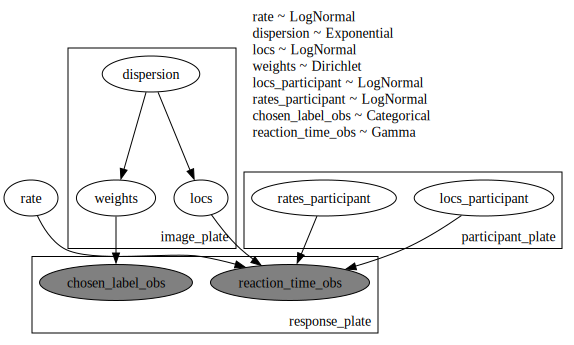

In [43]:
pyro.render_model(model, model_args=args, render_distributions=True, render_params=True)

# SVI

In [44]:
def fit(model, guide, args, lr=0.005, n_steps=1000, verbosity=100):
    pyro.clear_param_store()
    adam_params = {"lr": lr}
    adam = pyro.optim.Adam(adam_params)
    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for step in range(n_steps):
        loss = svi.step(*args)
        if step % verbosity == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

def param(name):
    return pyro.get_param_store()[name].data.numpy()

In [45]:
fit(model, AutoDelta(model), args)

[iter 0]  loss: 3450270248.7634
[iter 100]  loss: 1922664126.6108
[iter 200]  loss: 1213417056.3607
[iter 300]  loss: 829992766.8600
[iter 400]  loss: 598858640.3008
[iter 500]  loss: 447840874.8685
[iter 600]  loss: 342713237.5448
[iter 700]  loss: 267096664.0792
[iter 800]  loss: 212796849.6855
[iter 900]  loss: 173971124.1611


# Investigating results

In [46]:
dispersion = param('AutoDelta.dispersion')
df_disp = pd.DataFrame(zip(range(len(dispersion)), dispersion), columns=['image_id', 'dispersion'])

df_disp

,image_id,dispersion
0,0,0.243229
1,1,0.242919
2,2,0.240524
3,3,0.230917
4,4,0.240342
...,...,...
9995,9995,0.241011
9996,9996,0.266113
9997,9997,0.241158
9998,9998,0.232168


In [47]:
df = df.merge(df_disp)

df

,annotator_id,trial_index,is_attn_check,true_category,chosen_category,true_label,chosen_label,correct_guess,cifar10_test_test_idx,image_filename,subcategory,reaction_time,time_elapsed,image_id,category_id,dispersion
0,0,0,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1.342,1342,1791,8,0.234595
1,97,9,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,3.131,69671,1791,8,0.234595
2,122,29,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1.694,93018,1791,8,0.234595
3,176,207,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1.659,873425,1791,8,0.234595
4,227,55,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1.414,193612,1791,8,0.234595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514183,2376,128,0,ship,ship,8,8,1,3653,merchant_ship_s_000119.png,merchant_ship,1.689,294607,5694,8,0.279902
514184,2417,87,0,ship,ship,8,8,1,3653,merchant_ship_s_000119.png,merchant_ship,1.384,1005904,5694,8,0.279902
514185,2447,203,0,ship,ship,8,8,1,3653,merchant_ship_s_000119.png,merchant_ship,2.063,464993,5694,8,0.279902
514186,2482,65,0,ship,ship,8,8,1,3653,merchant_ship_s_000119.png,merchant_ship,1.500,129502,5694,8,0.279902


In [48]:
df_img = df.pivot_table(index=['cifar10_test_test_idx'], values=['dispersion'], aggfunc=np.mean)

most_uncertain = list(df_img.nlargest(16, columns=['dispersion']).index)
most_certain = list(df_img.nsmallest(16, columns=['dispersion']).index)

most_uncertain

[6750,
 5840,
 6024,
 86,
 8153,
 2232,
 1924,
 3357,
 5398,
 3463,
 5369,
 5158,
 5227,
 9924,
 6197,
 6792]

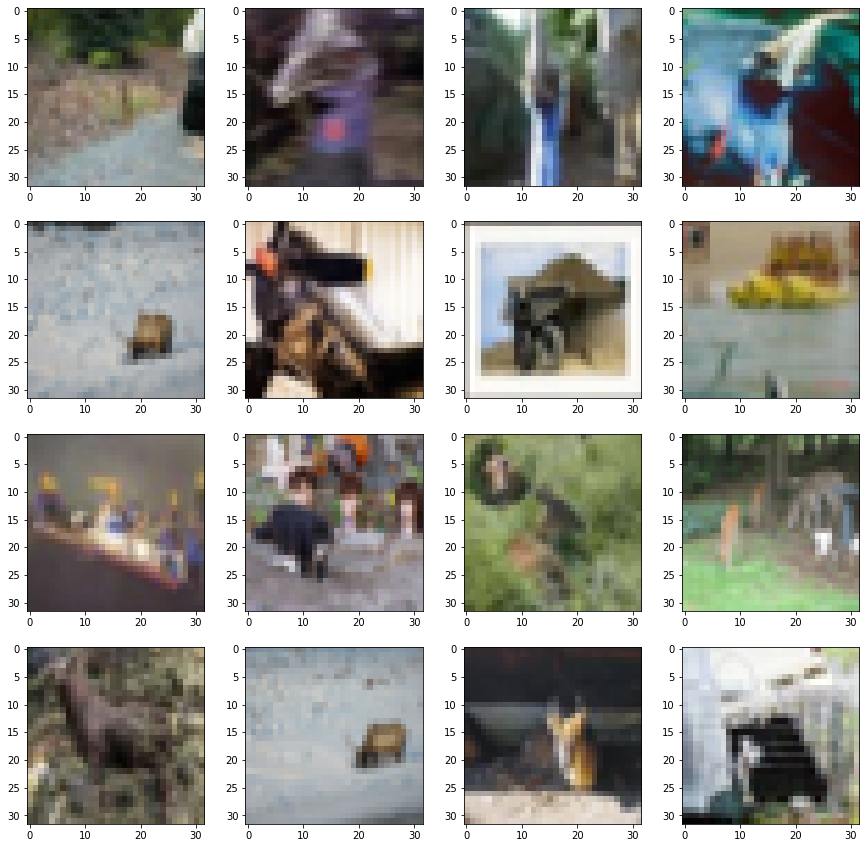

In [49]:
plot_grid(most_uncertain)

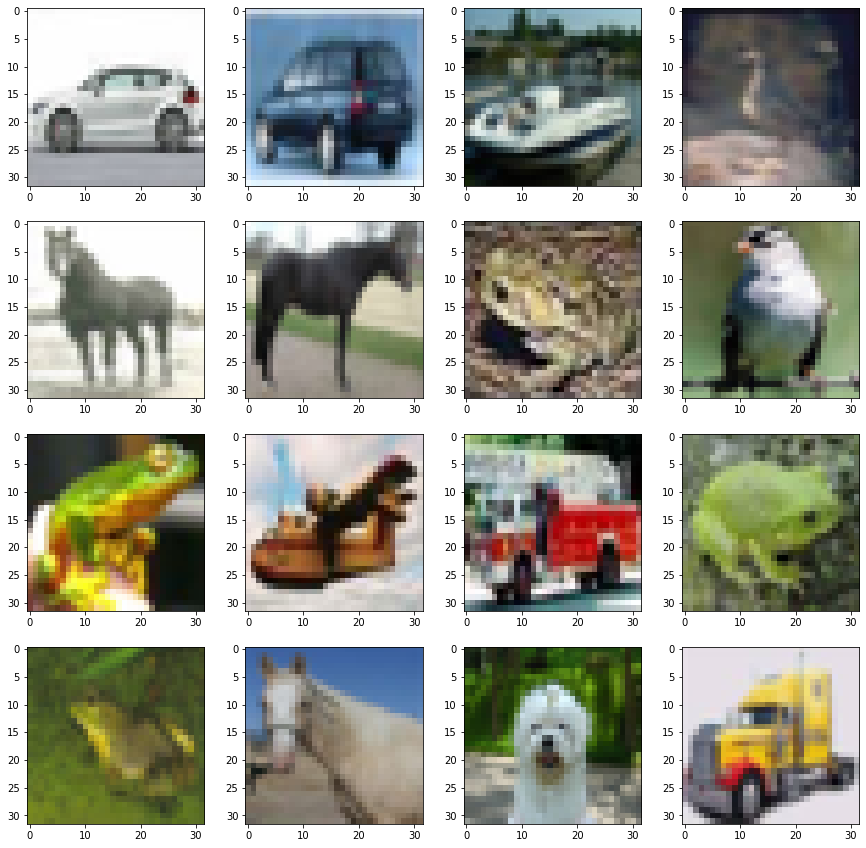

In [50]:
plot_grid(most_certain)